# Classifiez automatiquement des biens de consommation : Traitement de texte
## Importation des librairies et des données
### Importation des librairies python utilisées

In [14]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from textblob import TextBlob
import scipy.stats as stats

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

### Importation du jeu de données et visualisation des variables

In [2]:
raw_data = pd.read_csv('text_1050.csv')

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4]:
raw_data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


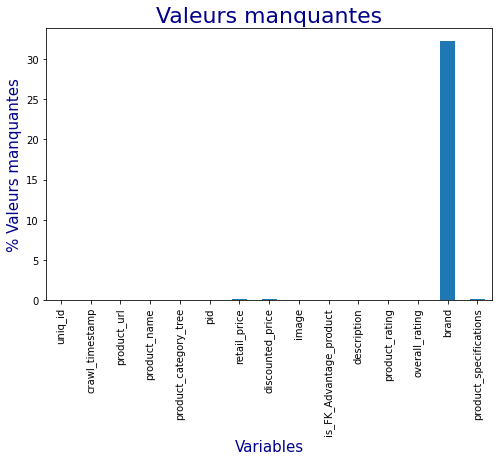

In [13]:
df_missing_values = raw_data.isnull().sum().divide(raw_data.shape[0]).multiply(100)

plt.figure(figsize=(8,5))
plt.title("Valeurs manquantes", fontsize=22, color='darkblue')
plt.xlabel("Variables", fontsize=15, color='darkblue')
plt.ylabel("% Valeurs manquantes", fontsize=15,color='darkblue')
df_missing_values.plot(kind="bar")

In [15]:
reindexed_data = raw_data['description']
reindexed_data.index = raw_data['image']

## Isolation des features importantes et prétraitement du texte

In [16]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    
    vectorized_description = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_description, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_description.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    most_frequent_words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (most_frequent_words, word_values[0,:n_top_words].tolist()[0])

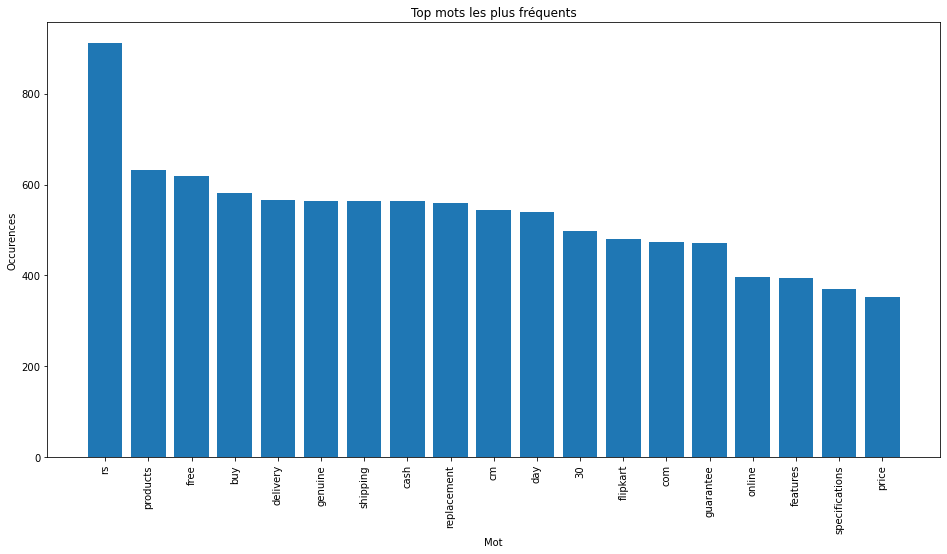

In [18]:
count_vectorizer = CountVectorizer(stop_words='english')
most_frequent_words, word_values = get_top_n_words(n_top_words=19,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(most_frequent_words)), word_values);
ax.set_xticks(range(len(most_frequent_words)));
ax.set_xticklabels(most_frequent_words, rotation='vertical');
ax.set_title('Top mots les plus fréquents');
ax.set_xlabel('Mot');
ax.set_ylabel('Occurences');
plt.show()

### Suppression des mots les plus fréquents, stopwords & punctuation

In [19]:
most_frequent_words

['rs',
 'products',
 'free',
 'buy',
 'delivery',
 'genuine',
 'shipping',
 'cash',
 'replacement',
 'cm',
 'day',
 '30',
 'flipkart',
 'com',
 'guarantee',
 'online',
 'features',
 'specifications',
 'price']

In [20]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import nltk
from string import punctuation

stop_words = set(stopwords.words('english'))
print(type(stop_words))

mots_a_supprimer = set.union(set(most_frequent_words),stop_words,punctuation)
print(type(mots_a_supprimer))

<class 'set'>
<class 'set'>


In [21]:
print(mots_a_supprimer)

{"she's", 'whom', 'ours', 'in', 'or', '@', '\\', 'an', 'flipkart', 'your', 'won', 'which', 'delivery', 'of', 'having', 'price', 'weren', 'were', 'below', 'did', 'now', 'by', '.', 'couldn', 'against', 'during', 'again', '>', "wasn't", 'same', "you're", 'her', 'shouldn', 'shipping', 'after', 'them', '+', 'about', 'further', 'been', 'some', ')', 'because', "shouldn't", '-', '[', '/', 'doesn', '<', '=', "it's", 'yourself', 'our', "hadn't", 'm', "shan't", 'has', '30', 'that', 'as', 'who', 'products', 'above', 'o', 'she', 'ain', '%', 'down', 'herself', 'then', 'if', 'myself', "don't", "hasn't", '|', 'genuine', "won't", 're', 'over', 'online', 'a', 'at', 'haven', 'mightn', '!', 'd', 'off', 'y', "isn't", "doesn't", 'up', 'where', '_', 'into', 'but', 'out', 'wasn', 'for', 'yours', 'why', 'when', 'and', 'most', "couldn't", 'such', 'him', 'they', 'theirs', 'me', "you'll", 'what', 'doing', 'no', "needn't", ';', 'i', 'cm', 'wouldn', 'ourselves', '^', "'", 'too', 'both', 'you', 'is', '`', 'replaceme

In [22]:
import re
for i in range (reindexed_data.shape[0]) :
  reindexed_data[i] = re.sub('[^A-Za-z]', ' ', reindexed_data[i]).lower()

<ipython-input-22-5aa9548263a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reindexed_data[i] = re.sub('[^A-Za-z]', ' ', reindexed_data[i]).lower()


In [23]:
reindexed_data[0]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain      cm in height  pack of    price  rs      this curtain enhances the look of the interiors this curtain is made from      high quality polyester fabric it features an eyelet style stitch with metal ring it makes the room environment romantic and loving this curtain is ant  wrinkle and anti shrinkage and have elegant apparance give your home a bright and modernistic appeal with these designs  the surreal attention is sure to steal hearts  these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening  you create the most special moments of joyous beauty given by the soothing prints  bring home the elegant curtain that softly filters light in your room so that you

In [24]:
def Tokenizer(str_input):
    words = word_tokenize(str_input)
    return words

In [25]:
tokenized_data = reindexed_data.copy()

for i in range(reindexed_data.shape[0]):
    tokenized_data[i]=Tokenizer(reindexed_data[i])
    
print(tokenized_data[0])

['key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'in', 'height', 'pack', 'of', 'price', 'rs', 'this', 'curtain', 'enhances', 'the', 'look', 'of', 'the', 'interiors', 'this', 'curtain', 'is', 'made', 'from', 'high', 'quality', 'polyester', 'fabric', 'it', 'features', 'an', 'eyelet', 'style', 'stitch', 'with', 'metal', 'ring', 'it', 'makes', 'the', 'room', 'environment', 'romantic', 'and', 'loving', 'this', 'curtain', 'is', 'ant', 'wrinkle', 'and', 'anti', 'shrinkage', 'and', 'have', 'elegant', 'apparance', 'give', 'your', 'home', 'a', 'bright', 'and', 'modernistic', 'appeal', 'with', 'these', 'designs', 'the', 'surreal', 'attention', 'is', 'sure', 'to', 'steal', 'hearts', 'these', 'contemporary', 'eyelet', 'and', 'valance', 'curtains', 'slide', 'smoothly', 'so', 'when', 'you', 'draw', 'them', 'apart', 'first', 'thing', 'in', 

In [26]:
tokenized_data = tokenized_data.apply(lambda x: ' '.join([word for word in x if word not in (mots_a_supprimer)]))

In [27]:
tokenized_data[0]

'key elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack curtain enhances look interiors curtain made high quality polyester fabric eyelet style stitch metal ring makes room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal designs surreal attention sure steal hearts contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor dimensions length box number contents sales package pack sales package cu

### Extraction de la racine

In [28]:
def Stemmer(str_input):
    str_input = str_input.lower()
    words = word_tokenize(str_input)
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
  
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [29]:
stemmed_tokenized_data = tokenized_data.copy()

for i in range(tokenized_data.shape[0]):
    stemmed_tokenized_data[i]=Stemmer(stemmed_tokenized_data[i])
    
print(stemmed_tokenized_data[0])

['key', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'curtain', 'enhanc', 'look', 'interior', 'curtain', 'made', 'high', 'qualiti', 'polyest', 'fabric', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environ', 'romant', 'love', 'curtain', 'ant', 'wrinkl', 'anti', 'shrinkag', 'eleg', 'appar', 'give', 'home', 'bright', 'modernist', 'appeal', 'design', 'surreal', 'attent', 'sure', 'steal', 'heart', 'contemporari', 'eyelet', 'valanc', 'curtain', 'slide', 'smoothli', 'draw', 'apart', 'first', 'thing', 'morn', 'welcom', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morn', 'whole', 'world', 'draw', 'close', 'even', 'creat', 'special', 'moment', 'joyou', 'beauti', 'given', 'sooth', 'print', 'bring', 'home', 'eleg', 'curtain', 'softli', 'filter', 'light', 'room', 'get', 'right', 'amount', 'sunlight', 'eleg', 'polyest', 'multicolor', 'ab

In [30]:
stemmed_tokenized_data = stemmed_tokenized_data.apply(lambda x: ' '.join([word for word in x]))
print(stemmed_tokenized_data[0])

key eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain height pack curtain enhanc look interior curtain made high qualiti polyest fabric eyelet style stitch metal ring make room environ romant love curtain ant wrinkl anti shrinkag eleg appar give home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlight eleg polyest multicolor abstract eyelet door curtain height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model id duster color multicolor dimens length box number content sale packag pack sale packag curtain bodi design materi polyest


In [31]:
tagged_headlines = [TextBlob(stemmed_tokenized_data[i]).pos_tags for i in range(stemmed_tokenized_data.shape[0])]
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per Description: ', np.mean(word_counts).round(0))

Total number of words:  47331
Mean number of words per Description:  45.0


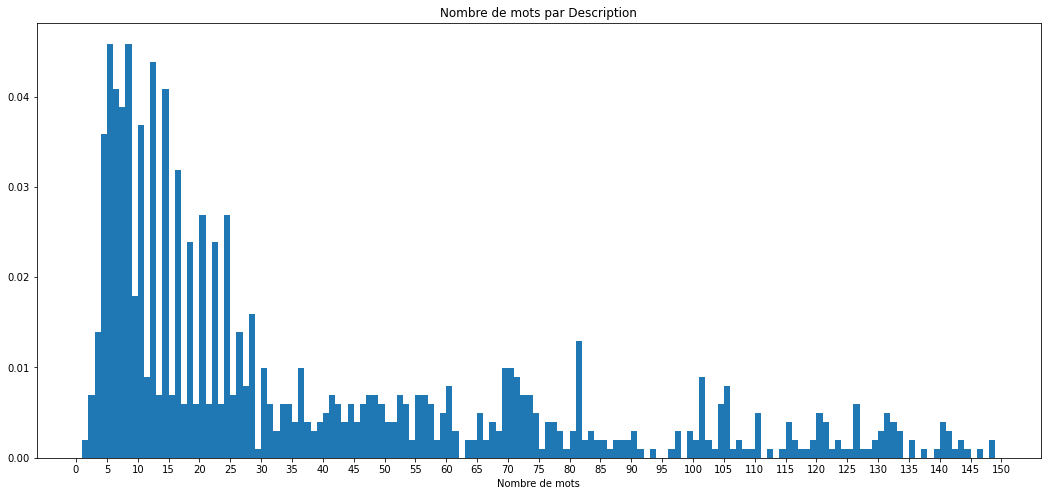

In [32]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,150), density=True);
ax.set_title('Nombre de mots par Description');
ax.set_xticks(range(0,155,5));
ax.set_xlabel('Nombre de mots');
plt.show()

### Vectorisation des Descriptions

In [49]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=50000)
small_text_sample = stemmed_tokenized_data.sample(n=1050).values

print('Description avant vectorization: {}'.format(small_text_sample[0]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Description après vectorization: \n{}'.format(small_document_term_matrix[0]))

Description avant vectorization: key print shape peacock feather laptop skin mous pad combo set glue remov inch laptop skin easi appli scratch resist lamin print shape peacock feather laptop skin mous pad combo set multicolor print shape laptop skin made high qualiti vinyl sheet compat laptop screen size rang inch inch trimn skin would requir per laptop size skin easi instal remov without leav gum residu print shape peacock feather laptop skin mous pad combo set multicolor gener brand print shape model name peacock feather laptop skin mous pad suitabl type laptop color multicolor warranti warranti summari warranti box number content sale packag pack
Description après vectorization: 
  (0, 1873)	1
  (0, 2723)	5
  (0, 3141)	5
  (0, 2537)	4
  (0, 1265)	4
  (0, 1942)	9
  (0, 3213)	8
  (0, 2267)	4
  (0, 2486)	4
  (0, 701)	3
  (0, 3122)	3
  (0, 1476)	1
  (0, 2901)	2
  (0, 1718)	3
  (0, 1068)	2
  (0, 157)	1
  (0, 3080)	1
  (0, 2921)	1
  (0, 1932)	1
  (0, 2287)	3
  (0, 1616)	1
  (0, 2794)	1
  

### Préparation de notre target
Nous préparons donc tout d'abord nos catégories.

In [65]:
categories = raw_data['product_category_tree']
categories.index = raw_data.image

for i in range (categories.shape[0]) :
  categories[i] = re.sub('[^A-Za-z]', ' ', categories[i]).lower()

<ipython-input-65-94eb2171bb66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories[i] = re.sub('[^A-Za-z]', ' ', categories[i]).lower()


In [66]:
print(categories)

image
55b85ea15a1536d46b7190ad6fff8ce7.jpg      home furnishing    curtains   accessories   ...
7b72c92c2f6c40268628ec5f14c6d590.jpg      baby care    baby bath   skin    baby bath t...
64d5d4a258243731dc7bbb1eef49ad74.jpg      baby care    baby bath   skin    baby bath t...
d4684dcdc759dd9cdf41504698d737d8.jpg      home furnishing    bed linen    bedsheets   ...
6325b6870c54cd47be6ebfbffa620ec7.jpg      home furnishing    bed linen    bedsheets   ...
                                                              ...                        
958f54f4c46b53c8a0a9b8167d9140bc.jpg      baby care    baby   kids gifts    stickers  ...
fd6cbcc22efb6b761bd564c28928483c.jpg      baby care    baby   kids gifts    stickers  ...
5912e037d12774bb73a2048f35a00009.jpg      baby care    baby   kids gifts    stickers  ...
c3edc504d1b4f0ba6224fa53a43a7ad6.jpg      baby care    baby   kids gifts    stickers  ...
f2f027ad6a6df617c9f125173da71e44.jpg      baby care    baby   kids gifts    stickers  ...
Name

In [67]:
tokenized_cat = categories.copy()

for i in range(tokenized_cat.shape[0]):
    tokenized_cat[i]=Tokenizer(tokenized_cat[i])
    
print(tokenized_cat[0])

['home', 'furnishing', 'curtains', 'accessories', 'curtains', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'do']


In [68]:
tokenized_cat = tokenized_cat.apply(lambda x: ' '.join([word for word in x if word not in (mots_a_supprimer)]))

In [69]:
tokenized_cat[0]

'home furnishing curtains accessories curtains elegance polyester multicolor abstract eyelet'

In [70]:
stemmed_tokenized_cat = tokenized_cat.copy()

for i in range(tokenized_cat.shape[0]):
    stemmed_tokenized_cat[i]=Stemmer(stemmed_tokenized_cat[i])
    
print(stemmed_tokenized_cat[0])

['home', 'furnish', 'curtain', 'accessori', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet']


In [71]:
Y = pd.DataFrame({'cat_name' : stemmed_tokenized_cat,
                    'image_name' : stemmed_tokenized_cat.index})
Y = Y.reset_index(drop=True)

Y.head()

,cat_name,image_name
0,"[home, furnish, curtain, accessori, curtain, e...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[babi, care, babi, bath, skin, babi, bath, tow...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[babi, care, babi, bath, skin, babi, bath, tow...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[home, furnish, bed, linen, bedsheet, santosh,...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[home, furnish, bed, linen, bedsheet, jaipur, ...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [72]:
Y['cat']=Y.cat_name

for i in range(Y.cat_name.shape[0]) :
    Y['cat'][i]=Y.cat_name[i][:2]

Y.cat = Y.cat.apply(lambda x: ' '.join([word for word in x]))

Y.head()

,cat_name,image_name,cat
0,"[home, furnish, curtain, accessori, curtain, e...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnish
1,"[babi, care, babi, bath, skin, babi, bath, tow...",7b72c92c2f6c40268628ec5f14c6d590.jpg,babi care
2,"[babi, care, babi, bath, skin, babi, bath, tow...",64d5d4a258243731dc7bbb1eef49ad74.jpg,babi care
3,"[home, furnish, bed, linen, bedsheet, santosh,...",d4684dcdc759dd9cdf41504698d737d8.jpg,home furnish
4,"[home, furnish, bed, linen, bedsheet, jaipur, ...",6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnish


In [73]:
Y.cat.value_counts()

kitchen dine      150
beauti person     150
babi care         150
home furnish      150
home decor        150
watch wrist       149
comput laptop      89
comput network     49
comput comput       6
comput tablet       3
comput storag       2
watch clock         1
comput softwar      1
Name: cat, dtype: int64

Nous créons désormais une variable traduisant numériquement nos catégories.

In [74]:
Y['label']=Y.cat

for i in range(Y.cat.shape[0]):
    if Y.cat[i]=='home furnish':
        Y.label[i]=0
    elif Y.cat[i]=='beauti person':
        Y.label[i]=1
    elif Y.cat[i]=='kitchen dine':
        Y.label[i]=2
    elif Y.cat[i]=='home decor':
        Y.label[i]=3
    elif Y.cat[i]=='babi care':
        Y.label[i]=4
    else :
        if Y.cat[i].__contains__('watch')==True:
            Y.label[i]=5
        else :
            Y.label[i]=6
            
Y.label.value_counts()

6    150
5    150
4    150
3    150
2    150
1    150
0    150
Name: label, dtype: int64

In [75]:
Y.drop('cat_name', axis=1).to_csv('images_categories.csv')

In [76]:
for i in range(7):
    print('Label number {}: '.format(i) , '{}'.format(Y.loc[Y.label==i, 'cat'][:1].values))


Label number 0:  ['home furnish']
Label number 1:  ['beauti person']
Label number 2:  ['kitchen dine']
Label number 3:  ['home decor']
Label number 4:  ['babi care']
Label number 5:  ['watch wrist']
Label number 6:  ['comput network']


Suite à cette analyse des catégories nous trouvons ici 7 principales thématiques : 
- 0. Home Furnishing
- 1. Beauty and Personal Care 
- 2. Kichen and Dining
- 3. Home Decoration
- 4. Baby Care
- 5. Watches
- 6. Computers

## LDA Topic Modelling

Une des méthodes non supervisées permettant de classifier nos descriptions de texte et la **Latent Dirichlet Allocation** (LDA), qui va regrouper les données selon les mots comportés dans les descriptions. 

### Création du modèle

Regardons ici ce que cela donne sur notre dataset (avec le nombre de topics recherché égal à 7 car nous connaissons déjà le nombres de catégories que nous allons utiliser).

In [50]:
n_topics = 7

In [51]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [52]:
def get_keys(topic_matrix):

    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):

    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [53]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [54]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
   
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

### Analyse de nos topics trouvés
Affichons maintenant les 15 mots les plus utilisés par topic afin de voir si nous pouvons en déduire des catégories de produit. 

In [55]:
top_n_words_lda = get_top_n_words(15, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  watch analog men india discount great women laptop dial skin strap print shape boy resist
Topic 2:  usb light cover design pack led cushion polyest color inch curtain materi box cotton power
Topic 3:  showpiec price best combo set skin oil soap type kadhai beauti lip oxyglow kit cream
Topic 4:  babi cotton girl fabric color pack gener box packag number type sale print materi ideal
Topic 5:  mug coffe ceram perfect gift design tea love ml pizza qualiti enjoy materi bring prithish
Topic 6:  warranti product adapt qualiti design laptop batteri materi size make set come power ceram gift
Topic 7:  wall sticker home design decor showpiec brass singl beauti quilt comfort look item appli product


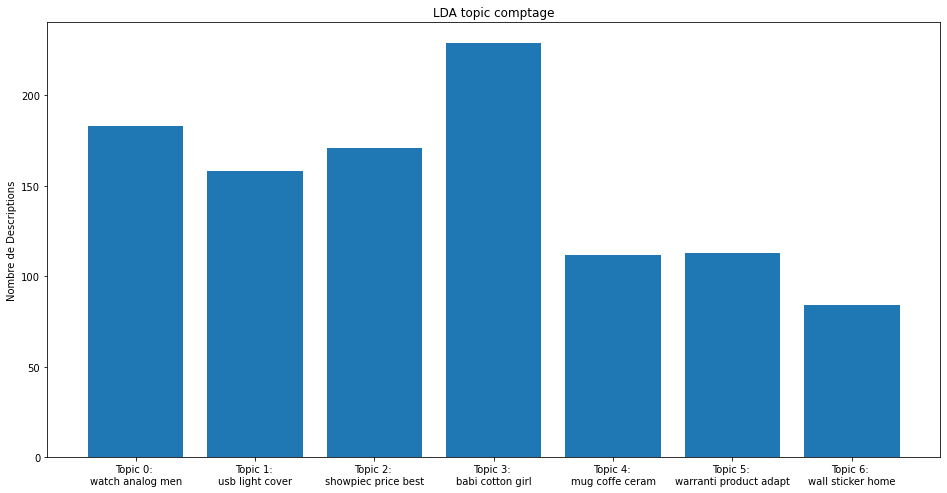

In [56]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic comptage');
ax.set_ylabel('Nombre de Descriptions');

### Représentation visuelle
Nous allons représenter visuellement ces Topics grâce à une TSNE qui va nous permettre de représenter chaque description produit selon deux composantes seulement. 

In [57]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.010767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.548122
[t-SNE] KL divergence after 2000 iterations: 0.264012


In [58]:
def get_mean_topic_vectors(keys, two_dim_vectors):
   
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [59]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [63]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering avec {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for i in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[i][0], y=lda_mean_topic_vectors[i][1], 
                  text=top_3_words_lda[i], text_color=colormap[i])
    plot.add_layout(label)

show(plot)

### Evaluation des résultats

In [122]:
original_labels = []

for i in range(len(Y.label.values)):
    original_labels.append(Y.label.values[i])

print("Accuracy: ", accuracy_score(original_labels, lda_keys))

Accuracy:  0.1457142857142857


In [98]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = [5,3,1,4,2,6,0]
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

lda_labels_transform = conf_mat_transform(original_labels, lda_keys)
conf_mat = confusion_matrix(original_labels, lda_labels_transform)
print(conf_mat)

Correspondance des clusters :  [5, 3, 1, 4, 2, 6, 0]
[[17 23 19 21 26 30 14]
 [14 26 13 25 27 25 20]
 [ 9 26 18 21 35 25 16]
 [11 18 14 23 38 22 24]
 [11 31 14 25 22 32 15]
 [11 22 14 26 40 28  9]
 [11 25 20 17 41 21 15]]


In [100]:
class_names = ['Home furnishing','Beauty and Personal Care','Kichen and Dining','Home Decoration','Baby Care',
               'Watches','Computers']

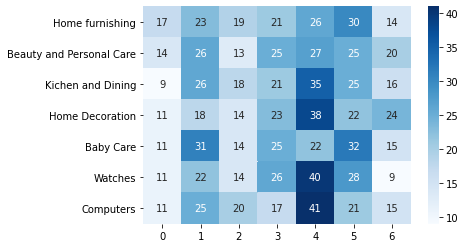

In [105]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sb.heatmap(df_cm, annot=True, cmap="Blues")

Cette LDA nous a permis de regrouper par descriptions similaires nos produits.
Cette méthode reste néanmoins peu précise, c'est pour cela que nous allons réaliser une classification en prenant comme cible la catégorie de chaque produit. 
## Classification de texte

Une autre option est d'utiliser un **modèle supervisé** de classification, dans notre étude nous utiliserons **RandomFrorest Classifier de la librairie SKlearn**.
Comme nous connaissons déjà les catégories de nos produits, nous allons pouvoir entraîner notre modèle à l'aides de celles-ci.

### Entraînement du modèle
Il est temps maintenant de réaliser notre classification. Nous allons donc vectorialiser nos descriptions, les séparers et Train & Test puis réaliser une Classification RandomForest.

In [107]:
count_vectorizer=CountVectorizer(stop_words='english',max_features=500)

vectorized_description = count_vectorizer.fit_transform(stemmed_tokenized_data.values)

print(vectorized_description[1])

  (0, 129)	2
  (0, 184)	1
  (0, 49)	1
  (0, 460)	1
  (0, 288)	2
  (0, 221)	1
  (0, 89)	1
  (0, 136)	1
  (0, 255)	1
  (0, 47)	1
  (0, 306)	1
  (0, 104)	1
  (0, 392)	2
  (0, 321)	2
  (0, 275)	1
  (0, 108)	3
  (0, 32)	6
  (0, 456)	6
  (0, 374)	2
  (0, 498)	2
  (0, 42)	2
  (0, 270)	1
  (0, 478)	1
  (0, 496)	1
  (0, 396)	1
  (0, 198)	1
  (0, 222)	1
  (0, 280)	1
  (0, 490)	1
  (0, 48)	1
  (0, 187)	1
  (0, 413)	1
  (0, 226)	2
  (0, 489)	1


In [108]:
X, y = vectorized_description, Y.label.values
y=y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [109]:
X_train_array = X_train.toarray()

In [110]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train_array, y_train)

RandomForestClassifier()

### Analyse des performances

In [111]:
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.9079365079365079


Text(0.5, 1.0, 'Matrice de confusion RFClassifier')

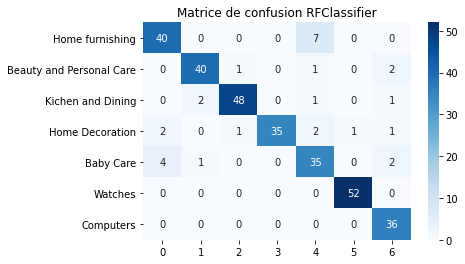

In [120]:
conf_mat_RFC = confusion_matrix(y_test, y_pred)

df_cm2 = pd.DataFrame(conf_mat_RFC, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sb.heatmap(df_cm2, annot=True, cmap="Blues")
plt.title("Matrice de confusion RFClassifier")

Sans même optimisations du modèle, nous obtenons une Accuracy de plus de 90%. Nous observons donc que la classification du texte des descriptions d'image est faisable et que nous avons tous les élément nécessaires à disposition. 

Nous allons passer désormais au traitement des images afin de voir s'il est possible d'en faire de même.